In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install allennlp-models
!pip install allennlp

     |████████████████████████████████| 430kB 13.0MB/s 
     |████████████████████████████████| 634kB 24.5MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 
     |████████████████████████████████| 122kB 32.0MB/s 
     |████████████████████████████████| 133kB 44.8MB/s 
     |████████████████████████████████| 266kB 50.0MB/s 
     |████████████████████████████████| 1.8MB 43.6MB/s 
     |████████████████████████████████| 2.1MB 48.9MB/s 
     |████████████████████████████████| 1.2MB 39.9MB/s 
     |████████████████████████████████| 7.6MB 43.6MB/s 
     |████████████████████████████████| 81kB 13.3MB/s 
     |████████████████████████████████| 133kB 53.5MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 174kB 55.8MB/s 
     |████████████████████████████████| 901kB 47.2MB/s 
     |████████████████████████████████| 3.3MB 45.2MB/s 
     |████████████████████████████████| 71kB 11.0MB/

In [3]:
from typing import Dict, Iterable, List

import torch
import pandas as pd
from allennlp.data import DatasetReader, Instance, Vocabulary, TextFieldTensors
from allennlp.data.fields import LabelField, TextField
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer, TokenCharactersIndexer
from allennlp.data.tokenizers import Token, Tokenizer, WhitespaceTokenizer, CharacterTokenizer
from allennlp.models import Model
from allennlp.modules import TextFieldEmbedder, Seq2VecEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding, TokenCharactersEncoder
from allennlp.modules.seq2vec_encoders import LstmSeq2VecEncoder, CnnEncoder
from allennlp.nn import util
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.data.data_loaders import MultiProcessDataLoader, DataLoader


In [74]:
class SentimentDataReader(DatasetReader):
    def __init__(
        self,
        tokenizer: Tokenizer = None,
        char_tokenizer: CharacterTokenizer = None,
        token_indexers: Dict[str, TokenIndexer] = None,
        max_tokens: int = None,
        label_col: str = 'sentiment',
        **kwargs
    ):
        super().__init__(**kwargs)
        self.tokenizer = tokenizer or WhitespaceTokenizer()
        self.char_tokenizer = char_tokenizer or CharacterTokenizer()
        if token_indexers is None:
            self.token_indexers = {
                    "tokens": SingleIdTokenIndexer(namespace="tokens"),
                    "token_characters": TokenCharactersIndexer(namespace="token_characters", min_padding_length=3)
                }
        else:
            self.token_indexers = token_indexers
        self.max_tokens = max_tokens
        self.label_col = label_col

    def text_to_instance(self, text, label):
        tokens = self.tokenizer.tokenize(text)
        if self.max_tokens:
                tokens = tokens[: self.max_tokens]

        text_field = TextField(tokens, self.token_indexers)
        fields = {
            "tokens": text_field
        }
        if label:
            fields['label'] = LabelField(label)
        return Instance(fields)

    def _read(self, file_path) -> Iterable[Instance]:
        if isinstance(file_path, str):
            df = pd.read_csv(file_path)
        elif isinstance(file_path, pd.DataFrame):
            df = file_path
        for _, row in df.iterrows():
            text = row['text']
            sentiment = row[self.label_col]
            yield self.text_to_instance(text, sentiment)


In [75]:
instances = SentimentDataReader().read('/content/drive/MyDrive/Learning/20202/NLP/data/val.csv')
c = 0
for i in instances:
  print(i)
  c+=1
  if c> 2:
    break

Instance with fields:
 	 tokens: TextField of length 6 with text: 
 		[giáo, trình, chưa, cụ, thể, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer', 'token_characters': 'TokenCharactersIndexer'} 
 	 label: LabelField with label: negative in namespace: 'labels'. 

Instance with fields:
 	 tokens: TextField of length 4 with text: 
 		[giảng, buồn, ngủ, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer', 'token_characters': 'TokenCharactersIndexer'} 
 	 label: LabelField with label: negative in namespace: 'labels'. 

Instance with fields:
 	 tokens: TextField of length 8 with text: 
 		[giáo, viên, vui, tính, ,, tận, tâm, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer', 'token_characters': 'TokenCharactersIndexer'} 
 	 label: LabelField with label: positive in namespace: 'labels'. 



In [76]:
df = pd.read_csv('/content/drive/MyDrive/Learning/20202/NLP/data/val.csv')
instances = SentimentDataReader().read(df)
c = 0
for i in instances:
  print(i)
  c+=1
  if c> 2:
    break

Instance with fields:
 	 tokens: TextField of length 6 with text: 
 		[giáo, trình, chưa, cụ, thể, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer', 'token_characters': 'TokenCharactersIndexer'} 
 	 label: LabelField with label: negative in namespace: 'labels'. 

Instance with fields:
 	 tokens: TextField of length 4 with text: 
 		[giảng, buồn, ngủ, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer', 'token_characters': 'TokenCharactersIndexer'} 
 	 label: LabelField with label: negative in namespace: 'labels'. 

Instance with fields:
 	 tokens: TextField of length 8 with text: 
 		[giáo, viên, vui, tính, ,, tận, tâm, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer', 'token_characters': 'TokenCharactersIndexer'} 
 	 label: LabelField with label: positive in namespace: 'labels'. 



In [77]:
from allennlp.training.metrics import CategoricalAccuracy, F1Measure

class SimpleClassifier(Model):
    def __init__(self,
                 vocab: Vocabulary,
                 embedder: TextFieldEmbedder,
                 encoder: Seq2VecEncoder):
        super().__init__(vocab)
        self.embedder = embedder
        self.encoder = encoder
        num_labels = vocab.get_vocab_size("labels")
        self.classifier = torch.nn.Linear(encoder.get_output_dim(), num_labels)
        self.accuracy = CategoricalAccuracy()
        self.f1_measure = F1Measure(1)

    def forward(self,
                tokens: Dict[str, torch.Tensor],
                label: torch.Tensor = None) -> Dict[str, torch.Tensor]:
        # Shape: (batch_size, num_tokens, embedding_dim)
        embedded_text = self.embedder(tokens)
        # Shape: (batch_size, num_tokens)
        mask = util.get_text_field_mask(tokens)
        # Shape: (batch_size, encoding_dim)
        encoded_text = self.encoder(embedded_text, mask)
        # Shape: (batch_size, num_labels)
        logits = self.classifier(encoded_text)
        # Shape: (batch_size, num_labels)
        probs = torch.nn.functional.softmax(logits)
        # Shape: (1,)
        output = {
            'probs': probs,
            'logits': logits
        }
        if label is not None:
            loss = torch.nn.functional.cross_entropy(logits, label)
            output['loss'] = loss
            self.accuracy(logits, label)
            self.f1_measure(logits, label)

        return output
    
    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        metrics_result = self.f1_measure.get_metric(reset)
        metrics_result['accuracy'] = self.accuracy.get_metric(reset)
        
        return metrics_result

In [78]:
import tempfile
from typing import Dict, Iterable, List, Tuple
import shutil
import os

import allennlp
import torch
from allennlp.data import (
    DataLoader,
    DatasetReader,
    Instance,
    Vocabulary,
    TextFieldTensors,
)
from allennlp.data.data_loaders import SimpleDataLoader
from allennlp.data.fields import LabelField, TextField
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data.tokenizers import Token, Tokenizer, WhitespaceTokenizer
from allennlp.models import Model
from allennlp.modules import TextFieldEmbedder, Seq2VecEncoder
from allennlp.modules.seq2vec_encoders import BagOfEmbeddingsEncoder
from allennlp.modules.token_embedders import Embedding
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.nn import util
from allennlp.training.trainer import GradientDescentTrainer, Trainer
from allennlp.training.optimizers import AdamOptimizer
from allennlp.training.metrics import CategoricalAccuracy


train_path = '/content/drive/MyDrive/Learning/20202/NLP/data/train.csv'
test_path = '/content/drive/MyDrive/Learning/20202/NLP/data/test.csv'
val_path = '/content/drive/MyDrive/Learning/20202/NLP/data/val.csv'

def build_model(
    vocab,
    embedding_dim=100,
    hidden_size=128,
    char_embedding_dim=34,
    dropout=0.4,
    bidirectional=True,
    word_embedding_pretrain_file=None
):
     # token embedding
    embedding = Embedding(embedding_dim=embedding_dim, vocab_namespace='tokens', vocab=vocab, pretrained_file=word_embedding_pretrain_file)
        
    # char embedding with cnnencoder
    character_embedding = Embedding(embedding_dim=char_embedding_dim, vocab_namespace='token_characters', vocab=vocab)
    cnn_encoder = CnnEncoder(embedding_dim=char_embedding_dim, num_filters=char_embedding_dim, ngram_filter_sizes=(3,))
    token_encoder = TokenCharactersEncoder(character_embedding, cnn_encoder)

    embedder = BasicTextFieldEmbedder(
        {
            "tokens": embedding,
            "token_characters": token_encoder
        }
    )
        
    encoder = LstmSeq2VecEncoder(input_size=embedder.get_output_dim(), hidden_size=hidden_size, num_layers=2, bidirectional=bidirectional, dropout=dropout)

    model = SimpleClassifier(
        vocab,
        embedder,
        encoder
    )
    model.to('cuda')
    return model

def build_dataset_reader(max_tokens=80, label_col='sentiment') -> DatasetReader:
    return SentimentDataReader(max_tokens=max_tokens, label_col=label_col)


def read_data(reader: DatasetReader, train_path, val_path) -> Tuple[List[Instance], List[Instance]]:
    print("Reading data")
    training_data = list(reader.read(train_path))
    validation_data = list(reader.read(val_path))
    return training_data, validation_data


def build_vocab(instances: Iterable[Instance]) -> Vocabulary:
    print("Building the vocabulary")
    return Vocabulary.from_instances(instances)

def build_data_loaders(
    train_data: List[Instance],
    dev_data: List[Instance],
    batch_size=64
) -> Tuple[DataLoader, DataLoader]:
    train_loader = SimpleDataLoader(train_data, batch_size, shuffle=True)
    dev_loader = SimpleDataLoader(dev_data, batch_size, shuffle=False)
    return train_loader, dev_loader

def build_trainer(
    model,
    serialization_dir,
    train_loader,
    dev_loader,
    num_epochs=7,
    grad_clipping=5,
    weight_decay=0.0001
):
    parameters = [(n, p) for n, p in model.named_parameters() if p.requires_grad]
    optimizer = AdamOptimizer(parameters, lr=0.001, weight_decay=weight_decay)  # type: ignore
    trainer = GradientDescentTrainer(
        model=model,
        serialization_dir=serialization_dir,
        data_loader=train_loader,
        validation_data_loader=dev_loader,
        num_epochs=num_epochs,
        optimizer=optimizer,
        grad_clipping=grad_clipping,
        cuda_device=0

    )
    return trainer

def run_training_loop(
    train_df,
    val_df,
    label_col='sentiment',
    serialization_dir='models',
    checkpoint=False,
    embedding_dim=100,
    hidden_size=128,
    char_embedding_dim=34,
    dropout=0.4,
    bidirectional=True,
    word_embedding_pretrain_file=None,
    num_epochs=7,
    grad_clipping=5,
    weight_decay=0.0001
):    

    print('num_epochs', num_epochs)
    print('word_embedding_pretrain_file', word_embedding_pretrain_file)
    print('dropout', dropout)
    print('grad_clipping', grad_clipping)
    print('weight_decay', weight_decay)
    if checkpoint is False:
        if os.path.exists(serialization_dir):
            shutil.rmtree(serialization_dir)

    dataset_reader = build_dataset_reader(max_tokens=80, label_col=label_col)

    train_data, dev_data = read_data(dataset_reader, train_df, val_df)

    vocab = build_vocab(train_data + dev_data)

    model = build_model( 
        vocab,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        char_embedding_dim=char_embedding_dim,
        dropout=dropout,
        bidirectional=bidirectional,
        word_embedding_pretrain_file=word_embedding_pretrain_file
      )

    train_loader, dev_loader = build_data_loaders(train_data, dev_data, batch_size=128)
    train_loader.index_with(vocab)
    dev_loader.index_with(vocab)

    trainer = build_trainer(model,
                            serialization_dir, 
                            train_loader, 
                            dev_loader,
                            num_epochs=num_epochs,
                            grad_clipping=grad_clipping,
                            weight_decay=weight_decay
                            )

  
    trainer.train()


    return model, dataset_reader

In [ ]:
from sklearn.model_selection import KFold


train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
df = pd.concat([train_df, val_df])

neutral_df = df[df['sentiment'] == 'neutral']
df = pd.concat([df, neutral_df, neutral_df])
splits = list(KFold(n_splits=8, shuffle=True, random_state=42).split(df))

model_folds = []
for fold, (train_idx, val_idx) in enumerate(splits):
    print('-'*40 + str(fold) + '-'*40)
    train_df_ = df.iloc[train_idx.tolist()]
    val_df_ = df.iloc[val_idx.tolist()]
    model_folds.append(
        run_training_loop(
            train_df=train_df_,
            val_df=val_df_,
            label_col='sentiment',
            serialization_dir='models',
            checkpoint=False,
            bidirectional=True,
            embedding_dim=100,
            hidden_size=128,
            char_embedding_dim=34,
            dropout=0.4,
            word_embedding_pretrain_file='/content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt',
            num_epochs=5,
            grad_clipping=5,
            weight_decay=0.0001
        )
    )
    


----------------------------------------0----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


building vocab:  10%|#         | 1422/14071 [00:00<00:00, 14219.81it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 153078.36it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
  0%|          | 0/97 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
precision: 0.7854, recall: 0.8916, f1: 0.8351, accuracy: 0.8158, batch_loss: 0.0776, loss: 0.4752 ||: 100%|##########| 97/97 [00:05<00:00, 16.33it/s]
precision: 0.8587, recall: 0.9338, f1: 0.8947, accuracy: 0.8795, batch_loss: 1.0772, loss: 0.3372 ||: 100%|##########| 14/14 [00:00<00:00, 47.57it/s]
precision: 0.9040, recall: 0.9352, f1: 0.9193, accuracy: 0.9072, batch_loss: 0.0899, loss: 0.2603 ||: 100%|##########| 97/97 [00:05<00:00, 16.38it/s]
precision: 0.9089, recall: 0.9377, f1: 0.9231, accuracy: 0.9125, batch_loss: 0.5287, loss: 0.2599 ||: 100%|##########| 14/14 [00:00<00:00, 49.99it/s]
precision: 0.9

----------------------------------------1----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


building vocab:  10%|#         | 1414/14071 [00:00<00:00, 14130.38it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 151879.07it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
precision: 0.7879, recall: 0.8732, f1: 0.8284, accuracy: 0.8080, batch_loss: 0.3006, loss: 0.4856 ||: 100%|##########| 97/97 [00:05<00:00, 16.68it/s]
precision: 0.8879, recall: 0.9287, f1: 0.9078, accuracy: 0.8835, batch_loss: 0.9400, loss: 0.3551 ||: 100%|##########| 14/14 [00:00<00:00, 46.44it/s]
precision: 0.9031, recall: 0.9380, f1: 0.9202, accuracy: 0.9072, batch_loss: 0.3854, loss: 0.2592 ||: 100%|##########| 97/97 [00:05<00:00, 16.83it/s]
precision: 0.9046, recall: 0.9427, f1: 0.9233, accuracy: 0.9119, batch_loss: 0.6375, loss: 0.2720 ||: 100%|##########| 14/14 [00:00<00:00, 40.90it/s]
precision: 0.9387, recall: 0.9571, f1: 0.9478, accuracy: 0.9393, batch_loss: 0.2135, loss: 0.1799 ||: 100%|##########| 97/97 [00:05<00:00, 16.62it/s]
precision: 0.9103, recall: 0.9439, f1: 0.9268, accuracy: 0.9164, batch_loss: 0.5795, los

In [93]:
def predict(model, text: str):
        tokens = [Token(token) for token in text.split(' ')]
        text_field = TextField(tokens, self._token_indexers)
        instance = Instance({
            "tokens": text_field
        })
        output = model.forward_on_instance(instance)
        y_prediction = np.argmax(output['probs'], axis=-1)
        y_probs = np.max(output['probs'], axis=-1)
        prediction = model.vocab.get_token_from_index(y_prediction, namespace='labels')
        return prediction

## Evaluate

In [94]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from typing import Dict
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(
        cm,
        target_names,
        title='Confusion matrix',
        cmap=None,
        normalize=True,
        save_dir='results'):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    width = int(10/7*len(target_names))

    height = int(8/7*len(target_names))

    # plt.figure(figsize=(width, height))
    plt.imshow(cm, cmap=cmap)
    # plt.title(title)
    plt.colorbar()

    if target_names:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if os.path.exists(save_dir) is False:
        os.mkdir(save_dir)

    try:
        print(f"Save confusion-matrix...")
        plt.savefig((save_dir + '/{}.png'.format(title)))
    except IOError:
        print(f"Could not save file in directory: {save_dir}")

    plt.show()

In [95]:
import numpy as np
def predict_kfold(model_folds, text: str):
    # print(text)
    tokens = [Token(token) for token in text.split(' ')]
    token_indexers = model_folds[0][1].token_indexers
    max_tokens = model_folds[0][1].max_tokens
    models = [x[0] for x in model_folds]
    vocab = model_folds[0][0].vocab

    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    text_field = TextField(tokens, token_indexers)
    instance = Instance({
        "tokens": text_field
    })
    outputs = [model.forward_on_instance(instance) for model in models]
    y_predictions = [np.argmax(output['probs'], axis=-1) for output in outputs]
    y_probs = [np.max(output['probs'], axis=-1) for output in outputs]
    predictions = [vocab.get_token_from_index(y_prediction, namespace='labels') for y_prediction in y_predictions]
    predictioin_final = max(predictions, key = predictions.count)
    return predictioin_final

In [96]:
predict_kfold(model_folds, "giảng viên nhiệt tình tâm huyết")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'positive'

In [97]:
vocab = model_folds[0][0].vocab

test_df = pd.read_csv(test_path)
texts = test_df['text'].tolist()
label_true = test_df['sentiment'].tolist()
label_pred = [predict_kfold(model_folds, text) for text in texts]
y_true = [vocab.get_token_index(label, namespace='labels') for label in label_true]
y_pred = [vocab.get_token_index(label, namespace='labels') for label in label_pred]

# get metric scores
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

labels = list(vocab.get_token_to_index_vocabulary('labels').keys())
report = classification_report(label_true, label_pred, labels=labels)
print(f'Evaluate ')
print('Accuracy :', acc)
print('Precision:', precision)
print('Recall   :', recall)
print('F1-Score :', f1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Evaluate 
Accuracy : 0.8960833859759949
Precision: 0.8024543642114197
Recall   : 0.7041948402296869
F1-Score : 0.7277143746112477


Save confusion-matrix...


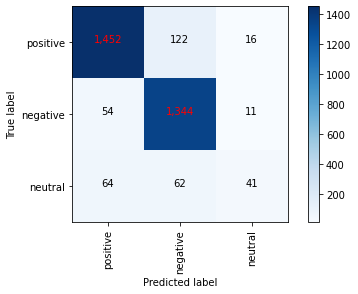

Save confusion-matrix...


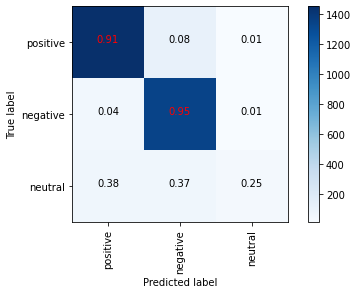

In [98]:
cm = confusion_matrix(label_true, label_pred, labels=labels)
plot_confusion_matrix(cm, target_names=labels, title=f'Confusion Matrix (sentiment)', normalize=False)
plot_confusion_matrix(cm, target_names=labels, title=f'Confusion Matrix Normalize (sentiment)', normalize=True)

In [89]:

test_df_false = test_df[test_df['sentiment'] != test_df['sentiment_pred']]
test_df_false.to_csv('/content/drive/MyDrive/Learning/20202/NLP/false_sent_pred.csv', index=False)

test_df_true = test_df[test_df['sentiment'] == test_df['sentiment_pred']]
test_df_true.to_csv('/content/drive/MyDrive/Learning/20202/NLP/true_sent_pred.csv', index=False)

TypeError: ignored